In [2]:
!apt install -y ffmpeg

'apt' is not recognized as an internal or external command,
operable program or batch file.


In [1]:
import numpy as np 
import pandas as pd 
from IPython.display import Audio 
import librosa 
import librosa.display 
from sklearn.preprocessing import StandardScaler
import sys


%matplotlib inline
import matplotlib.pyplot as plt 
import seaborn as sns

In [2]:
AUDIO_FILE = 'scrum.wav'
y, sr = librosa.load(AUDIO_FILE)

In [3]:
print('Sampled Data Shape: ', y.shape)
print('Sampling Rate: ', sr)
      

Sampled Data Shape:  (1697850,)
Sampling Rate:  22050


In [4]:
Audio(data=y, rate=sr)

In [5]:
totDuration = librosa.get_duration(filename=AUDIO_FILE)
print("Total Duration(s): ", totDuration)

Total Duration(s):  77.0


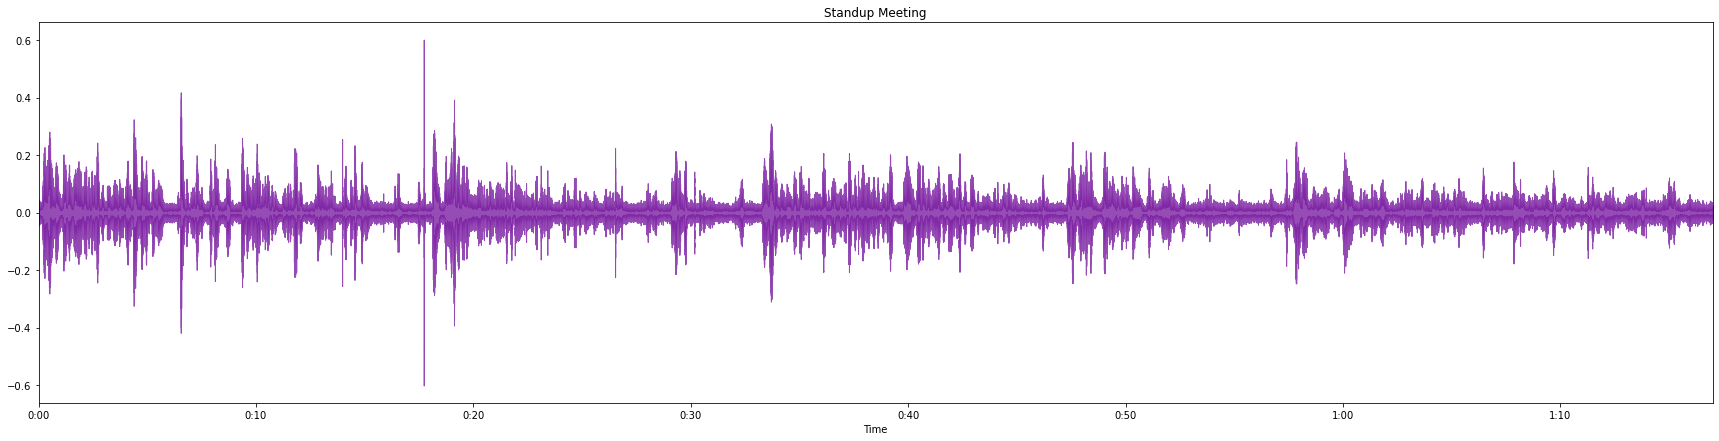

In [6]:
# Amplitude v Time
plt.figure(figsize=(30, 7))
librosa.display.waveplot(y, sr, color='#7B1FA2', alpha=0.8)
plt.title('Standup Meeting')
plt.show()

In [7]:
# Create chunks/windows for feeding into the model
division_per_second = 1
chunk_time = 1.0 / division_per_second
chunk_size = sr // division_per_second
print('Samples in one chunk (chunk size)', chunk_size)
print('Duration of one chunk', chunk_time)
print('Number of chunks: ', y.shape[0]//chunk_size)


Samples in one chunk (chunk size) 22050
Duration of one chunk 1.0
Number of chunks:  77


In [8]:
remainder_chunks = y.shape[0] % chunk_size
num_of_chunks = 1
if(remainder_chunks>0):
    num_of_chunks = y[:-remainder_chunks].shape[0]/chunk_size
    Y = np.split(y[:-remainder_chunks], num_of_chunks)
else:
    num_of_chunks = y.shape[0]/chunk_size
    Y = np.split(y, num_of_chunks)
print(chunk_size)
len(Y)
print(Y[0])

22050
[-0.00446841 -0.01161395 -0.00615434 ...  0.00321737  0.00771482
  0.01397744]


In [9]:
# Extract feature: Mel-frequency Cepstral Coefficients
feature_mfcc = np.array([ librosa.feature.mfcc(y=chunk, sr=sr, n_mfcc = 40) for chunk in Y ])
feature_mfcc.shape
feature_mfcc_mean = np.mean(feature_mfcc, axis = 2)
print(feature_mfcc_mean.shape)

(77, 40)


In [10]:
# Extract feature: Spectral flatness
feature_spectral_flatness = np.array([librosa.feature.spectral_flatness(y=y) for chunk in Y])
feature_spectral_flatness.shape
feature_spectral_flatness_mean = np.mean(feature_spectral_flatness, axis = 2)
print(feature_spectral_flatness_mean.shape)

(77, 1)


In [11]:
# Extract feature: Spectral flux
feature_specflux = np.array([librosa.onset.onset_strength(y=y, sr=sr) for chunk in Y])
feature_specflux.shape
feature_specflux_mean = np.mean(feature_specflux, axis = 1).reshape(-1,1)
print(feature_specflux_mean.shape)

(77, 1)


In [12]:
# Extract feature: Pitch
feature_pitches = np.array([librosa.piptrack(y=y, sr=sr)[0] for chunk in Y])
feature_pitches.shape
feature_pitches_mean = np.mean(feature_pitches, axis = 2)
print(feature_pitches_mean.shape)

(77, 1025)


In [13]:
#Create final feature space for feeding into the model
X = np.hstack((
    feature_mfcc_mean,
    feature_spectral_flatness_mean,
    feature_specflux_mean,
    feature_pitches_mean
))
X.shape

(77, 1067)

In [14]:
# Normalize the input
scaler = StandardScaler()
X = scaler.fit_transform(X)
X.shape

(77, 1067)

In [15]:
from sklearn.mixture import GaussianMixture
nclusters = 6
gmm = GaussianMixture(n_components=nclusters)
gmm.fit(X)

GaussianMixture(n_components=6)

In [16]:
op = gmm.predict(X)
time_speaker = {}
for i in range(len(op)):
    time_speaker[i+1] = str(op[i])

print(time_speaker)

{1: '5', 2: '5', 3: '5', 4: '5', 5: '0', 6: '5', 7: '5', 8: '5', 9: '5', 10: '5', 11: '5', 12: '5', 13: '4', 14: '4', 15: '5', 16: '4', 17: '4', 18: '4', 19: '2', 20: '3', 21: '2', 22: '3', 23: '3', 24: '3', 25: '2', 26: '4', 27: '4', 28: '4', 29: '4', 30: '4', 31: '4', 32: '4', 33: '4', 34: '1', 35: '1', 36: '1', 37: '1', 38: '1', 39: '1', 40: '1', 41: '1', 42: '1', 43: '1', 44: '1', 45: '1', 46: '4', 47: '4', 48: '1', 49: '1', 50: '1', 51: '1', 52: '1', 53: '1', 54: '4', 55: '4', 56: '4', 57: '4', 58: '2', 59: '2', 60: '2', 61: '2', 62: '2', 63: '2', 64: '2', 65: '2', 66: '2', 67: '2', 68: '2', 69: '2', 70: '2', 71: '4', 72: '2', 73: '2', 74: '2', 75: '4', 76: '4', 77: '4'}


In [17]:
# Segmentation Algorithm

def getCount(time_speaker, cluster, wstart, wend):
    count = 0
    lastSeenAt = None
    for i in range(wstart, wend+1):
        if(time_speaker[i] == cluster):
            count += 1
            lastSeenAt = i
    return (count, lastSeenAt)

def getSuccessor(time_speaker, currentCluster, wstart, params):
    totalDuration = len(time_speaker)
    lookahead = int(params['lookaheadTime']/chunk_time)
    i = wstart
    successorCount = 0
    while(i <= totalDuration - lookahead):
        j = i + lookahead
        successor = time_speaker[i]
        if(successor == currentCluster):
            return (i, successor)
        successorCount = getCount(time_speaker, successor, i, j)
        if(successorCount[0] > int(params['epsilon']/chunk_time)):
            return (i, successor)
        i += 1
    i = min(i + lookahead, totalDuration)
    return (i, time_speaker[i])
            
def getBreakPoint(time_speaker, cluster, wstart, params):
    totalDuration = len(time_speaker)
    i = wstart
    end = None
    while(time_speaker[i] == cluster):
        i += 1
    breaker = time_speaker[i]
    j = min(i + int(params['lookaheadTime']/chunk_time), totalDuration)
    breakerCount = getCount(time_speaker, breaker, i, j)
    clusterCount = getCount(time_speaker, cluster, i, j)
    if(breakerCount[0] >= int(params['epsilon']/chunk_time)): 
        end = i
    else:
        i += 1
        successor = getSuccessor(time_speaker, cluster, i, params)
        if(successor[1] == cluster):
            i = successor[0]
            end = getBreakPoint(time_speaker, cluster, i, params)
        else:
            end = successor[0]
    return end

def segment(time_speaker, params):
    segments = {}
    totalDuration = len(time_speaker)
    w = 1
    recorded = {}
    while(w <= totalDuration):
        cluster = time_speaker[w]
        print('Current cluster: ', cluster)
        start = None
        end = None
        if(recorded.get(cluster) == None):
            i = w
            j = min(w + int(params['lookaheadTime']/chunk_time), totalDuration)
            count = getCount(time_speaker, cluster, i, j)
            print("Count in lookahead window: " + 'cluster: '+ cluster, count[0])
            if(count[0] > int(params['epsilon']/chunk_time)):
                start = i
                end = getBreakPoint(time_speaker, cluster, start, params)
                w = end-1
                print('End of '+cluster+' is : ', end)
                segments[cluster] = (start, end)            
                recorded[cluster] = True
                continue
        w += 1         
    return segments

params = {
    'lookaheadTime' : 7,
    'epsilon' : 4
}
segments = segment(time_speaker, params)
segments


Current cluster:  5
Count in lookahead window: cluster: 5 7
End of 5 is :  13
Current cluster:  5
Current cluster:  4
Count in lookahead window: cluster: 4 5
End of 4 is :  34
Current cluster:  4
Current cluster:  1
Count in lookahead window: cluster: 1 8
End of 1 is :  54
Current cluster:  1
Current cluster:  4
Current cluster:  4
Current cluster:  4
Current cluster:  4
Current cluster:  2
Count in lookahead window: cluster: 2 8
End of 2 is :  71
Current cluster:  2
Current cluster:  4
Current cluster:  2
Current cluster:  2
Current cluster:  2
Current cluster:  4
Current cluster:  4
Current cluster:  4


{'5': (1, 13), '4': (13, 34), '1': (34, 54), '2': (58, 71)}

In [26]:
from scipy.io import wavfile
import math

speakers = {}
rate, data = wavfile.read('scrum.wav')
i = 1
for k in segments:
    start = math.ceil(rate * segments[k][0] * chunk_time)
    end = math.ceil(rate * segments[k][1] * chunk_time)
    speakers[i] = data[start:end+1]
    i += 1

speakers
for i in speakers:
    wavfile.write('segments/sp'+str(i)+'.wav', rate, speakers[i])
    
len(speakers)
    
    

6

In [30]:
# Speech to text

import speech_recognition as sr 
import os 
from pydub import AudioSegment
from pydub.silence import split_on_silence
import pandas as pd

# speech recognizer
recognizer = sr.Recognizer()
directoryPath="./segments/"

#split audio file into chunks and convert audio to text
def get_audio_paths(path):
    audio = AudioSegment.from_wav(path)  
    # split audio sound where silence is 700 miliseconds or more and get chunks
    chunks = split_on_silence(audio,min_silence_len = 1000,silence_thresh = audio.dBFS-9,keep_silence=800)
    folder_name = directoryPath+"/chunks"
    # store chunks in the following directory (create if not exists)
    if not os.path.isdir(folder_name):
        os.mkdir(folder_name)
    final_text = ""
    # for each chunk 
    for i, chunk in enumerate(chunks, start=1):

        filename = os.path.join(folder_name, f"chunk{i}.wav")
        chunk.export(filename, format="wav")
        # recognize the audio
        with sr.AudioFile(filename) as source:
            recognizer.adjust_for_ambient_noise(source,duration=0.4)
            audio_listened = recognizer.record(source)
            # convert audio to text
            try:
                text = recognizer.recognize_google(audio_listened)
                print(text)
            except sr.UnknownValueError as e:
                print("Error:", str(e))
            else:
                final_text += text.lower()+ "."
    return final_text

paths=[]
for i,file in enumerate(os.listdir(directoryPath)):
    if file.endswith(".wav"):
        print(os.path.basename(file))
        paths.append(os.path.basename(file))

text_array=[]
for i, path in enumerate(paths):
    text_array.append( get_audio_paths(directoryPath+path))

dataframe=pd.DataFrame(text_array, columns=['Text']) 
dataframe.to_csv("samp.csv")
    
for text in text_array:
    print(text)



sp1.wav
sp2.wav
sp3.wav
sp4.wav
sp5.wav
sp6.wav
shopping baskets
and suggest me shoes with a cantaloupe carbs so somebody
images and Zyrtec and
metro news yesterday
patience pain and work some of the bugs that you a Vaso switch into so go to do a couple more but I think it should be okay
Pantry Crest changing
shopping baskets.
and suggest me shoes with a cantaloupe carbs so somebody.
images and zyrtec and.
metro news yesterday.
patience pain and work some of the bugs that you a vaso switch into so go to do a couple more but i think it should be okay.
pantry crest changing.


In [32]:
# Text clustering

from nltk import word_tokenize, pos_tag
import pandas as pd 
import csv

# data in excel sheet with Column "Text"
statusFile = 'status.csv'
df = pd.read_csv(statusFile, index_col=0);

def extract_tense(sentence):
    text = word_tokenize(sentence.lower())
    taggs = pos_tag(text)
    print(taggs)

    tense = {}
    tense["past"] = len([word for word in taggs if word[1] in ["VBD", "VBN"]])
    tense["present"] = len([word for word in taggs if word[1] in ["VBP", "VBZ","VBG"]])
    tense["future"] = len([word for word in taggs if word[1] in ["MD","VBC", "VBF"]])
     
    if(tense["future"]==0 and tense["present"]==0 and tense["past"]==0):
        return "2"
    if(tense["future"] >= tense["present"]):
        if(tense["future"] >= tense["past"]):
            #future
            return 1
        else:
            #"past"
            return -1
    elif(tense["future"] < tense["present"]):
        if(tense["present"] > tense["past"]):
            #present
            return 0
        
        else:
            #past
            return -1

# 
df=df.dropna()
speech_obj={}
speech_obj["work has been done"]=[]
speech_obj["work planned to do"]=[]
speech_obj["reported issues"]=[]
count=1
f = open('final_report.csv', 'w')
fnames = ['category', 'speaker','speech']
writer = csv.DictWriter(f, fieldnames=fnames)
with f:
    writer.writeheader()
    for index,row in df.iterrows():
        print(row.Text)
        speech = row.Text.split(".")
        for sentence in speech:
            previous_form=-2
            #print(sentence, determine_tense_input(sentence))
            if(extract_tense(sentence) == -1):
                writer.writerow({'category':'work has been done' , 'speaker': "speaker"+str(count),"speech":sentence})
                speech_obj["work has been done"].append({"speaker"+str(count):sentence})
                previous_form=-1
            elif(extract_tense(sentence) == 0):
                speech_obj["reported issues"].append({"speaker"+str(count):sentence})
                writer.writerow({'category':'reported issues' , 'speaker': "speaker"+str(count),"speech":sentence})
                previous_form=0
            elif(extract_tense(sentence) == 1):
                speech_obj["work planned to do"].append({"speaker"+str(count):sentence})
                writer.writerow({'category':'work planned to do' , 'speaker': "speaker"+str(count),"speech":sentence})
                previous_form=1
            else:
                if(previous_form == -1):
                    writer.writerow({'category':'work has been done' , 'speaker': "speaker"+str(count),"speech":sentence})
                    speech_obj["work has been done"].append({"speaker"+str(count):sentence})
                elif(previous_form == -0):
                    speech_obj["reported issues"].append({"speaker"+str(count):sentence})
                    writer.writerow({'category':'reported issues' , 'speaker': "speaker"+str(count),"speech":sentence})
                else:
                    speech_obj["work planned to do"].append({"speaker"+str(count):sentence})
                    writer.writerow({'category':'work planned to do' , 'speaker': "speaker"+str(count),"speech":sentence})
                    
        count=count+1



print("\nwork has been done\n")
for item in speech_obj["work has been done"]:
    print(item)

print("\nreported issues\n") 
for item in speech_obj["reported issues"]:
    print(item)

print("\nwork planned to do\n")
for item in speech_obj["work planned to do"]:
    print(item)


yesterday, I started working on creating the docker image for claim regression test data. Created dumps for
member, member group, provider, and provider organization data. I still have to create dumps from claims, and pricing data.
Once that is done, I will run the regression tests and push the final docker image to the docker hub. Apart from this, I am having 
issues with the claim adjudication service. I am working with John on them.
[('yesterday', 'NN'), (',', ','), ('i', 'NN'), ('started', 'VBD'), ('working', 'VBG'), ('on', 'IN'), ('creating', 'VBG'), ('the', 'DT'), ('docker', 'NN'), ('image', 'NN'), ('for', 'IN'), ('claim', 'NN'), ('regression', 'NN'), ('test', 'NN'), ('data', 'NNS')]
[('yesterday', 'NN'), (',', ','), ('i', 'NN'), ('started', 'VBD'), ('working', 'VBG'), ('on', 'IN'), ('creating', 'VBG'), ('the', 'DT'), ('docker', 'NN'), ('image', 'NN'), ('for', 'IN'), ('claim', 'NN'), ('regression', 'NN'), ('test', 'NN'), ('data', 'NNS')]
[('created', 'VBN'), ('dumps', 'NNS'), ('f